In [ ]:
import pymc3 as pm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=2)

In [ ]:
%load_ext rpy2.ipython

%matplotlib inline

polls = pd.read_csv("../ARM_Data/election88/polls.csv", index_col=0)

import copy

polls_sub = copy.deepcopy(polls.sample(1000))

polls_sub = polls_sub.dropna()

polls_clean = polls.dropna()

polls.head()

%%R -i polls_clean
library(lme4)
M1 <- glmer(bush ~ black + female + (1|state), polls_clean, family=binomial(link="logit"))
M1

## Radon Data

In [2]:
radon_full = pd.read_csv("../ARM_Data/radon/srrs2.dat", index_col=0)

In [3]:
radon = pd.DataFrame()

radon["floor"] = radon_full[" floor"]

radon["county"] = radon_full[" county"]

radon["log_radon"] = np.log(radon_full[" activity"]+1e-1)

radon = radon[radon_full[" state"].str.contains("MN")]

In [4]:
county = pd.Categorical(radon['county']).codes

with pm.Model() as hm:
    # County hyperpriors
    mu_a = pm.Normal('mu_a', mu=0, tau=1.0/100**2)
    sigma_a = pm.Uniform('sigma_a', lower=0, upper=100)
    mu_b = pm.Normal('mu_b', mu=0, tau=1.0/100**2)
    sigma_b = pm.Uniform('sigma_b', lower=0, upper=100)

    # County slopes and intercepts
    a = pm.Normal('intercept', mu=mu_a, sd=sigma_a, shape=len(set(county)))
    b = pm.Normal('slope', mu=mu_b, tau=1.0/sigma_b**2, shape=len(set(county)))

    # Household errors
    sigma = pm.Gamma("sigma", alpha=10, beta=1)

    # Model prediction of radon level
    mu = b[county]*radon["floor"].values + a[county]

    # Data likelihood
    y = pm.Normal('y', mu=mu, sd=sigma, observed=radon["log_radon"])

In [5]:
with hm:

    # obtain starting values via MAP
    start = pm.find_MAP()

    # instantiate sampler
    step = pm.Slice()

    # draw 1 posterior samples
    trace = pm.sample(100, step=step, start=start)

logp = -354.86, ||grad|| = 1.1782e+08: 100%|██████████| 306/306 [00:00<00:00, 823.90it/s]       
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma_log__]
>Slice: [intercept]
>Slice: [slope]
>Slice: [sigma_b_interval__]
>Slice: [mu_b]
>Slice: [sigma_a_interval__]
>Slice: [mu_a]
100%|██████████| 600/600 [01:26<00:00,  6.97it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


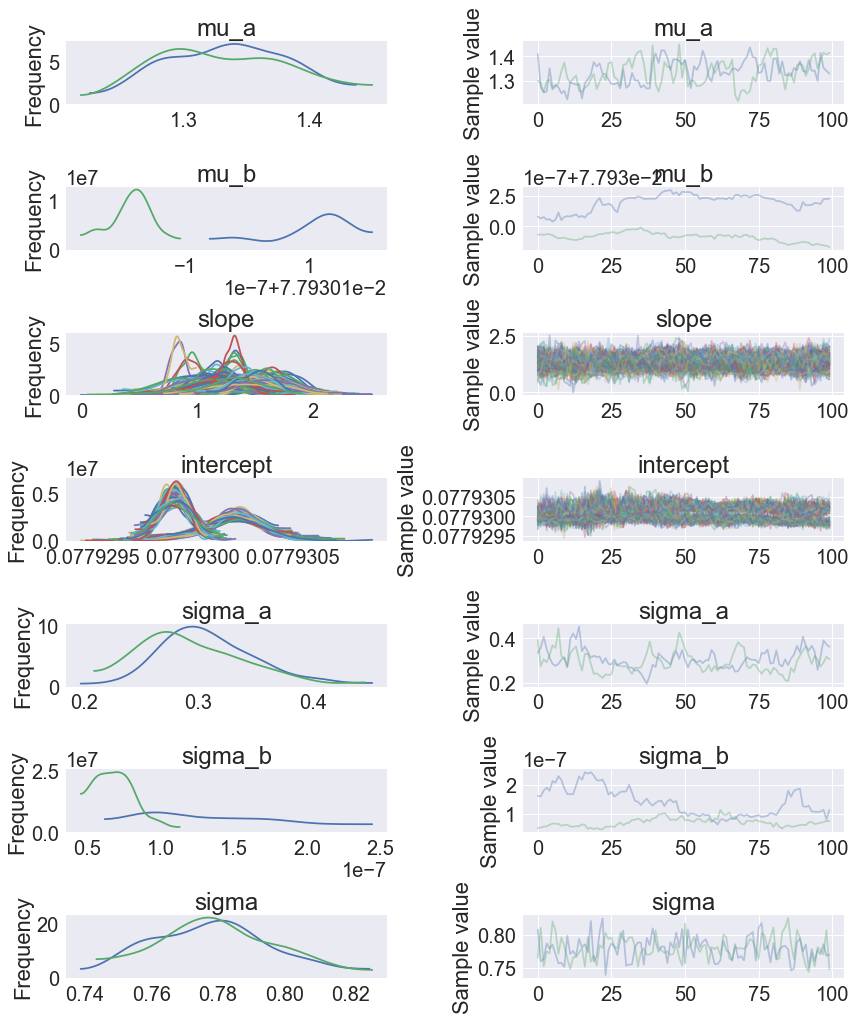

In [6]:
pm.traceplot(trace);

In [10]:
# radon[radon["county"].str.contains("HENNEPIN")]

In [11]:
county_idx = 25
first_county_instance = np.argwhere(county == county_idx).flatten()[0]
county_name = radon.iloc[first_county_instance]["county"].strip()

In [12]:
single_county_data = radon[radon["county"].str.contains(county_name)]

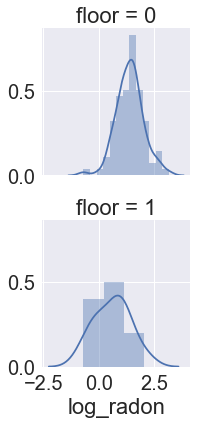

In [13]:
g = sns.FacetGrid(single_county_data, row="floor")
g.map(sns.distplot, "log_radon");
# sns.distplot(hennepin_data["log_radon"])

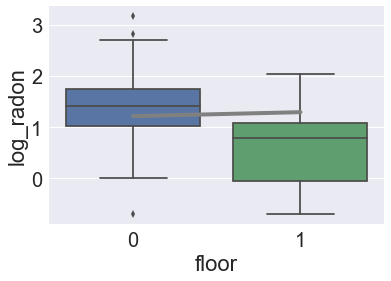

In [14]:
random_intercept = np.random.choice(trace["slope"][:,county_idx])
random_slope = np.random.choice(trace["intercept"][:,county_idx])
sns.boxplot(x="floor", y="log_radon", data=single_county_data);
plt.plot([0,1], [random_intercept,random_intercept+random_slope],
         linewidth=4, zorder=5, color='gray');